In [12]:
#IMPORT LIBRARIES
import gymnasium as gym
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions
from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [13]:
df = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\FinRL\data\META.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-02-28,162.369995,163.500000,160.860001,161.449997,161.278885,11114200
1,2019-03-01,162.600006,163.130005,161.690002,162.279999,162.108002,11097800
2,2019-03-04,163.899994,167.500000,163.830002,167.369995,167.192596,18894700
3,2019-03-05,167.369995,171.880005,166.550003,171.259995,171.078476,28187900
4,2019-03-06,172.899994,173.570007,171.270004,172.509995,172.327148,21531700


In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [15]:
df.sort_values('Date', ascending=True, inplace=True)
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-28,162.369995,163.500000,160.860001,161.449997,161.278885,11114200
2019-03-01,162.600006,163.130005,161.690002,162.279999,162.108002,11097800
2019-03-04,163.899994,167.500000,163.830002,167.369995,167.192596,18894700
2019-03-05,167.369995,171.880005,166.550003,171.259995,171.078476,28187900
2019-03-06,172.899994,173.570007,171.270004,172.509995,172.327148,21531700


In [16]:
env = gym.make('stocks-v0', df=df, frame_bound=(20, 1000), window_size=20)

c:\Users\abhis\Anaconda3\envs\env\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (20, 2)
  logger.warn(


info: {'total_reward': 38.84999084472656, 'total_profit': 0.03924715843337872, 'position': <Positions.Short: 0>}


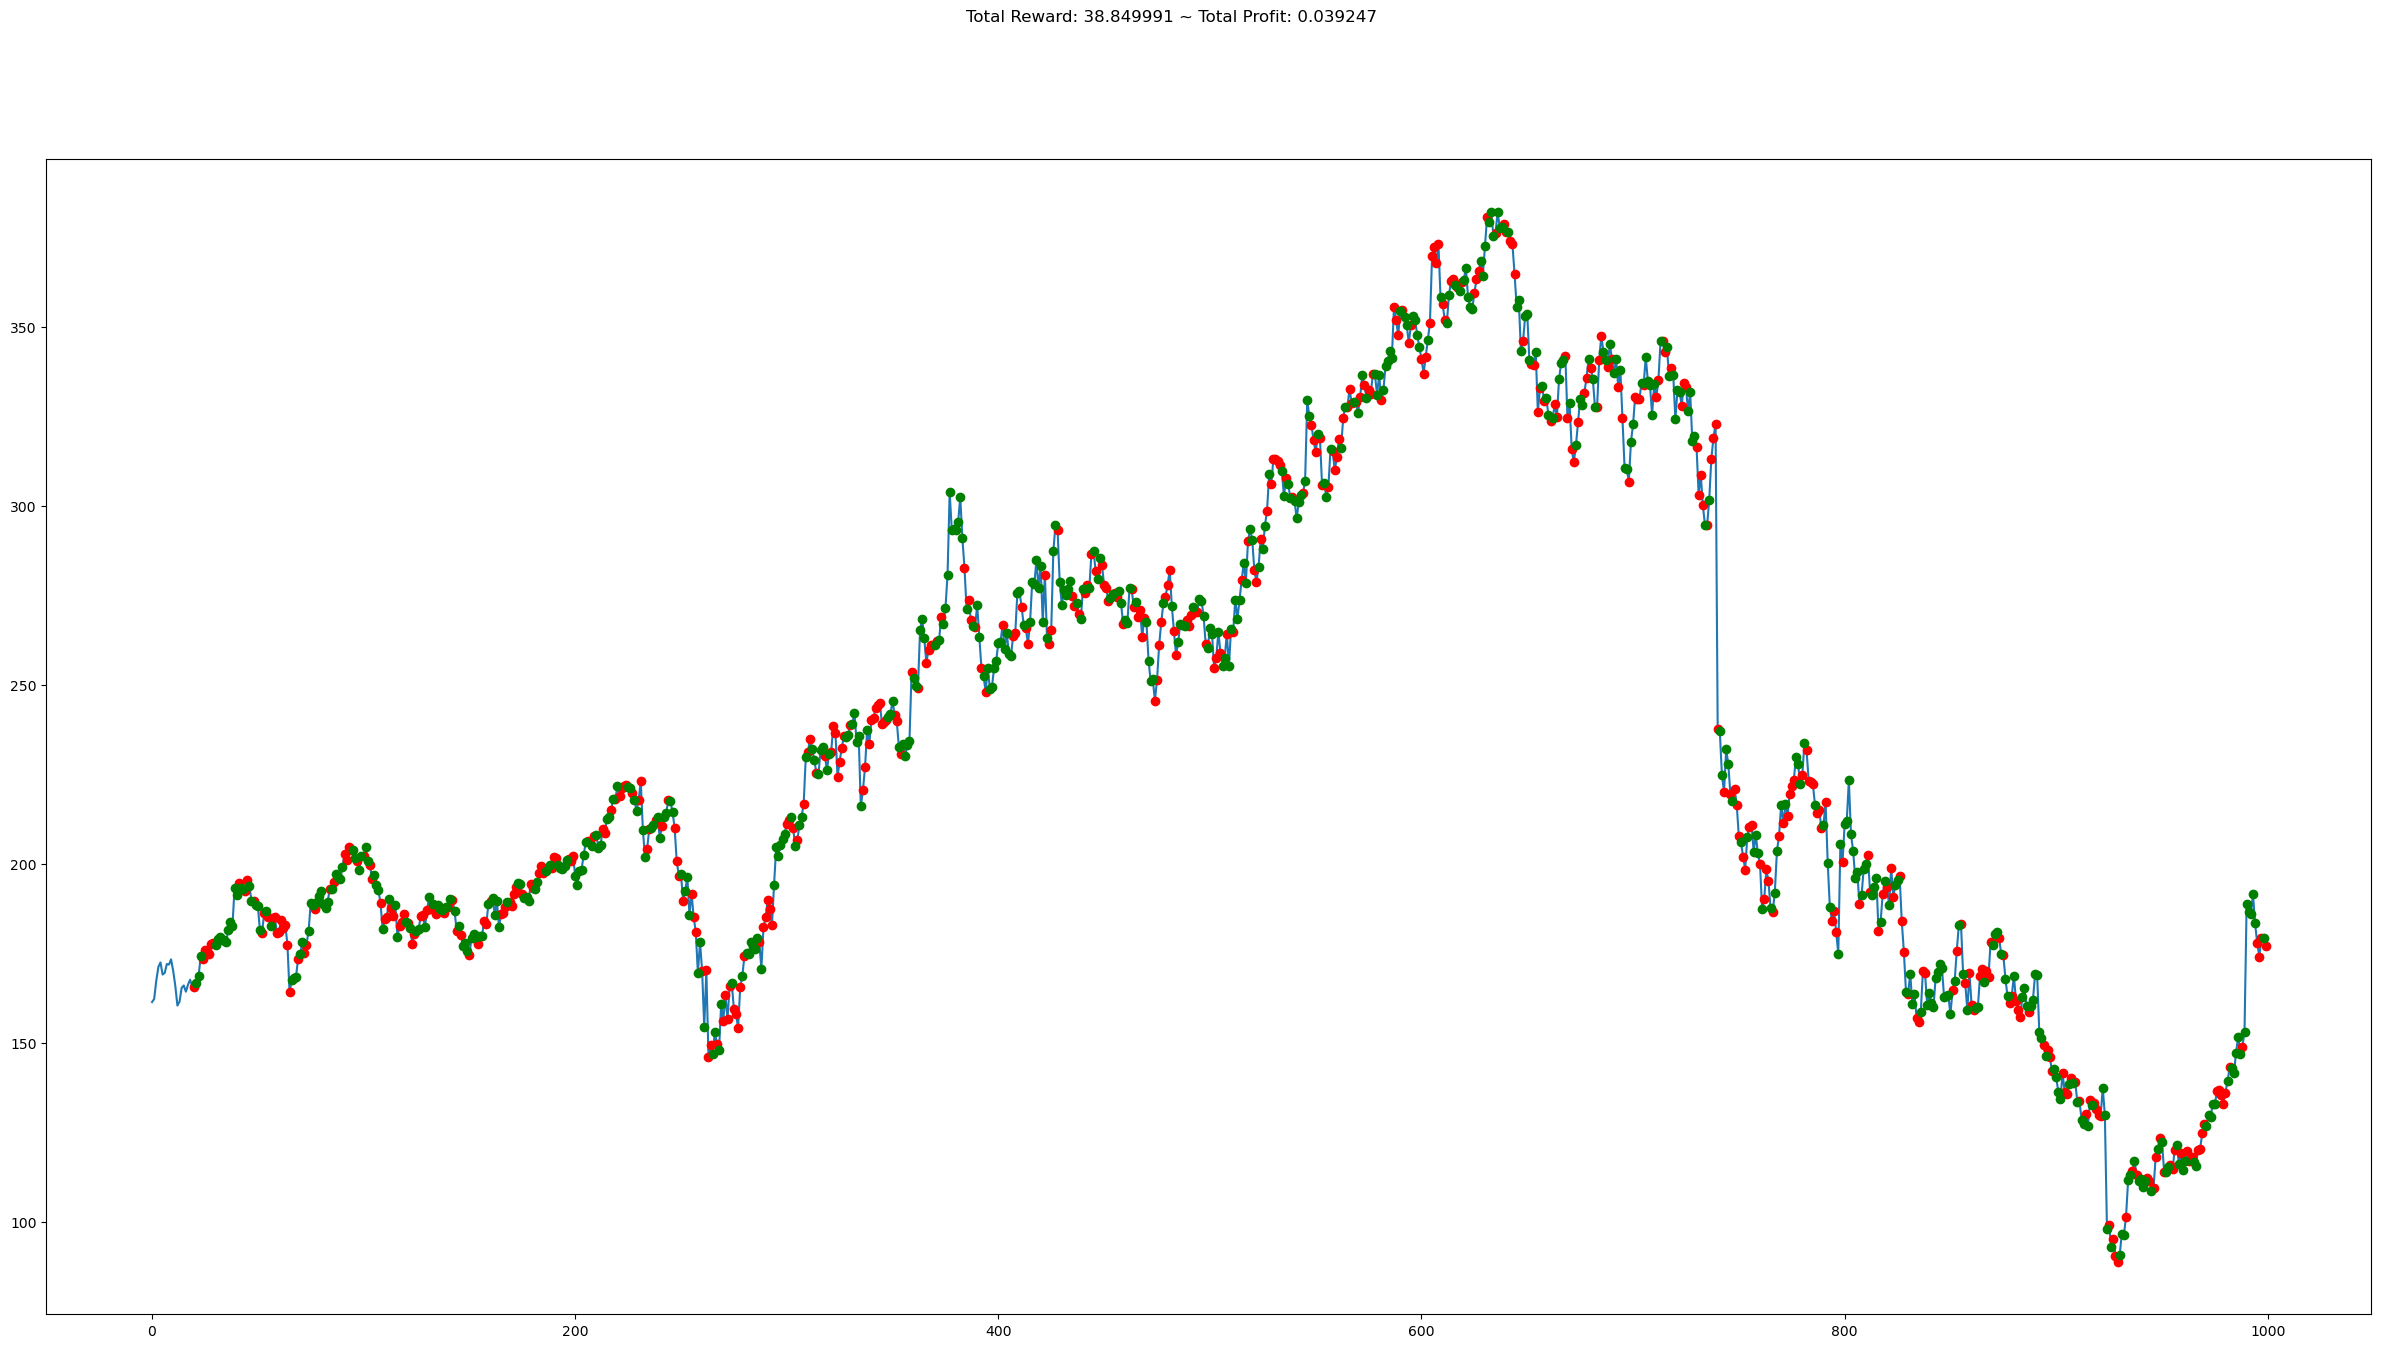

In [17]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break
plt.figure(figsize=(30, 15))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [18]:
df['Volume'] = df['Volume'].astype(float)
df['SMA'] = TA.SMA(df, 20)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)

df.fillna(0, inplace=True)

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume', 'SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [19]:
class CustomTradingEnv(StocksEnv):
    _process_data = add_signals

#CREATE UPDATED STOCK ENV
env2 = CustomTradingEnv(df=df, window_size=12, frame_bound=(20, 1000))
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [20]:

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=250_000)

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 20346    |
|    time_elapsed     | 0        |
|    total_timesteps  | 3916     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.702    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 20058    |
|    time_elapsed     | 0        |
|    total_timesteps  | 7832     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 20076    |
|    time_elapsed     | 0        |
|    total_timesteps  | 11748    |
----------------------------------
----------------------------------
| 

In [21]:
env = CustomTradingEnv(df=df, window_size=12, frame_bound=(1000, 1250))
obs, _ = env.reset()

while True:
    action, _states = model.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 251.18006799999995, 'total_profit': 1.941341001778003, 'position': <Positions.Long: 1>}


In [1]:
plt.figure(figsize=(23, 9))
plt.cla()
env.render_all()
plt.show()

NameError: name 'plt' is not defined